## Лабораторная работа № 3

Требуется разработать программу для имитационного моделирования системы массового обслуживания с использованием фреймворка SimPy. Система имеет $s_1$ устройств, каждое из которых может одновременно обслуживать только одно требование. Интервалы времени между поступлением требований являются независимыми случайными величинами со средним значением $\mu_a$.

Время обслуживания является случайной величиной, некоррелированной с интервалами поступления требований. Среднее значение времени обслуживания требований – $\mu_{s_1}$. В соответствии с данными варианта подобрать аналог реальной системы и продумать логику ее работы. В зависимости от выбранного аналога и логики его работы в систему могут быть добавлены дополнительные ресурсы. Их параметры (время обслуживания и др.) подбираются самостоятельно, исходя из работы реальных систем.

Провести оптимизацию системы по выбранному параметру.

| Кол-во устройств, $s_1$ | Среднее время обработки требования, $\mu_{s_1}$, с | Среднее время поступления требований, $\mu_a$, с |
|-------------------------|----------------------------------------------------|--------------------------------------------------|
| 2                       | 0.8                                                | 0.8                                              |


In [58]:
!pip install simpy numpy matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Импорт библиотек и инициализация параметров системы:

In [59]:
import simpy
import numpy as np
import math
import matplotlib.pyplot as plt

Среднее количество запросов в системе за время работы $T$ может быть вычислено как
$$
L = \cfrac{\int\limits_{0}^{T} N(t)\text{d}t}{T},
$$
где $N(t)$ -- количество запросов в системе в момент времени $t$.
(будем вычислять интеграл методом прямоугольников)

Средний коэффициент использования $s$ серверов за время работы $T$:
$$
\rho_{\text{serv}} = \cfrac{\int\limits_{0}^{T} F(t)\text{d}t}{s \cdot T},
$$
где $F(t)$ -- количество занятых серверов в момент времени $t$.

In [60]:
def init_metrics():
    """Create an empty metrics dict."""
    return dict(
        n_in_system=0,
        area_in_system=0.0,
        last_n_change=0.0,
        busy_servers=0,
        busy_area=0.0,
        last_busy_change=0.0,
        wait_server=[],
        wait_total=[],
        response=[],
        arrived=0, 
        completed=0
    )

def update_n(metrics, now, delta):
    """Time-average N(t) via area under curve."""
    metrics['area_in_system'] += metrics['n_in_system'] * (now - metrics['last_n_change'])
    metrics['last_n_change'] = now
    metrics['n_in_system'] += delta

def update_busy(metrics, now, delta):
    """Time-average busy servers via area under curve."""
    metrics['busy_area'] += metrics['busy_servers'] * (now - metrics['last_busy_change'])
    metrics['last_busy_change'] = now
    metrics['busy_servers'] += delta

def init_resources(env, serv_cap=2, use_cache=True, cache_cap=1, use_log=True, log_cap=1):
    """Create SimPy resources according to flags."""
    assert serv_cap >= 1 
    assert cache_cap >= 1 or not use_cache
    assert log_cap >= 1 or not use_log
    servers = simpy.Resource(env, capacity=serv_cap)
    cache = simpy.Resource(env, capacity=cache_cap) if use_cache else None
    logger = simpy.Resource(env, capacity=log_cap) if use_log else None
    return dict(servers=servers, cache=cache, logger=logger)

Рассчитываем общее среднее время ожидания в очереди для одного запроса как
$$
W^{(q)}_{\text{sys}}
= W^{(q)}_{\text{cache}}
+ (1-p_{\text{hit}})\,W^{(q)}_{\text{srv}}
+ W^{(q)}_{\text{log}}.
$$

Полное среднее время пребывания: сумма среднего времени ожидания и обслуживания на пройденных стадиях.
$$
W
= W^{(q)}_{\text{cache}} + \mu_{\text{log}}
+ (1-p_{\text{hit}})\left(W^{(q)}_{\text{srv}}+\frac{1}{\mu}\right)
+ W^{(q)}_{\text{log}} + \mu_{\text{log}}.
$$

In [61]:
def handle_request(env, rng, params, res, metrics, req_id):
    """One request goes through cache → servers (on miss) → logger."""
    t0 = env.now
    wq_sum = 0.0

    # cache step: always looked up
    if res['cache'] is not None:
        with res['cache'].request() as rq:
            t_queue = env.now
            yield rq
            wq_sum += env.now - t_queue
            yield env.timeout(rng.exponential(scale=params['cache_mean']))
        hit = (rng.random() < params['p_hit'])
    else:
        hit = False  # no cache → must go to servers

    # servers: only if not a cache hit
    if not hit:
        with res['servers'].request() as rq:
            t_queue = env.now
            yield rq
            wq = env.now - t_queue
            wq_sum += wq
            metrics['wait_server'].append(wq)
            update_busy(metrics, env.now, +1)
            yield env.timeout(rng.exponential(scale=params['serv_mean']))
            update_busy(metrics, env.now, -1)

    # logger: always
    if res['logger'] is not None:
        with res['logger'].request() as rq:
            t_queue = env.now
            yield rq
            wq_sum += env.now - t_queue
            yield env.timeout(rng.exponential(scale=params['log_mean']))

    metrics['wait_total'].append(wq_sum)
    metrics['response'].append(env.now - t0)
    metrics['completed'] += 1
    update_n(metrics, env.now, -1)

def arrival_process(env, rng, params, res, metrics, sim_time):
    """Poisson arrivals with mean interarrival arr_mean, stop spawning near sim_time."""
    i = 0
    while True:
        ia = rng.exponential(scale=params['arr_mean'])
        yield env.timeout(ia)
        if env.now > sim_time:
            break
        i += 1
        metrics['arrived'] += 1
        update_n(metrics, env.now, +1)
        env.process(handle_request(env, rng, params, res, metrics, i))

По итогу вычислений найдём следующие метрики:
- $\rho_\text{srv}$: Коэффициент использования серверов с ИИ
- $W^{(q)}_{\text{sys}}$: Полное среднее время ожидания в системе
- $W^{(q)}_{\text{srv}}$: Среднее время ожидания перед сервером
- $L$: Среднее число требований в системе
- $X$: Абсолютная пропускная способность системы
- $X_\text{rel}$: Относительная пропускная способность системы 
- $W$: Полное среднее время прибывания в системе

In [62]:
def finalize_areas(metrics, now):
    """Close the time integrals at the end of the run."""
    metrics['area_in_system'] += metrics['n_in_system'] * (now - metrics['last_n_change'])
    metrics['last_n_change'] = now
    metrics['busy_area'] += metrics['busy_servers'] * (now - metrics['last_busy_change'])
    metrics['last_busy_change'] = now

def compute_kpis(metrics, sim_time, serv_cap, arr_mean):
    """Return all KPIs the teacher listed."""
    finalize_areas(metrics, sim_time)
    util = metrics['busy_area'] / (sim_time * serv_cap) if sim_time > 0 else 0.0
    wq_system = float(np.mean(metrics['wait_total'])) if metrics['wait_total'] else 0.0
    wq_servers = float(np.mean(metrics['wait_server'])) if metrics['wait_server'] else 0.0
    l = metrics['area_in_system'] / sim_time if sim_time > 0 else 0.0
    x = metrics['completed'] / sim_time if sim_time > 0 else 0.0
    lam = 1.0 / arr_mean
    x_rel = x / lam if lam > 0 else 0.0
    w = float(np.mean(metrics['response'])) if metrics['response'] else 0.0
    return dict(utilization=util, Wq_system=wq_system, Wq_servers=wq_servers,
                L=l, X=x, X_rel=x_rel, W=w,
                completed=metrics['completed'], arrived=metrics['arrived'])

def run_once(sim_time=900, seed=1,
             arr_mean=0.8, serv_mean=0.8, serv_cap=2,
             use_cache=True,  cache_mean=0.03, cache_cap=1, p_hit=0.5,
             use_log=True,    log_mean=0.05,  log_cap=1):
    """Single replication; returns KPIs."""
    assert sim_time > 0 and arr_mean > 0 and serv_mean > 0
    assert 0.0 <= p_hit <= 1.0
    rng = np.random.default_rng(seed)
    env = simpy.Environment()

    params = dict(arr_mean=arr_mean, serv_mean=serv_mean, serv_cap=serv_cap,
                  use_cache=use_cache, cache_mean=cache_mean, cache_cap=cache_cap, p_hit=p_hit,
                  use_log=use_log,   log_mean=log_mean,   log_cap=log_cap)
    metrics = init_metrics()
    res = init_resources(env, serv_cap=serv_cap, use_cache=use_cache, cache_cap=cache_cap,
                         use_log=use_log, log_cap=log_cap)
    env.process(arrival_process(env, rng, params, res, metrics, sim_time))
    env.run(until=sim_time)
    k = compute_kpis(metrics, sim_time, serv_cap, arr_mean)

    # quick sanity checks
    assert 0.0 <= k['utilization'] <= 1.0 + 1e-9
    assert k['X'] >= 0 and k['X_rel'] >= 0
    return k

# quick smoke run + simple assert: p_hit=1 means servers unused
k_baseline = run_once(sim_time=3600, seed=123)
k_hit1 = run_once(sim_time=3600, seed=123, p_hit=1.0)
assert k_hit1['Wq_servers'] < 1e-6 and k_hit1['utilization'] < 1e-6
print("Smoke tests passed. Baseline KPIs:", k_baseline)

Smoke tests passed. Baseline KPIs: {'utilization': 0.25031680980495336, 'Wq_system': 0.02409253929703165, 'Wq_servers': 0.040361319182697405, 'L': 0.6281925674176289, 'X': 1.2461111111111112, 'X_rel': 0.9968888888888889, 'W': 0.5038294248939326, 'completed': 4486, 'arrived': 4487}


Повторим эксперимент несколько раз и с более длительным временем симуляции, после чего возьмём средние значения метрик:

In [72]:
def replicate(n=5, **kwargs):
    rows = [run_once(seed=i, **kwargs) for i in range(n)]
    keys = rows[0].keys()
    agg = {k: float(np.mean([r[k] for r in rows])) for k in keys}
    return agg, rows

def print_kpis(title, k):
    print(title)
    print('\t' f"utilization:               {k['utilization']:.4f}")
    print('\t' f"avg waiting in system:     {k['Wq_system']:.4f} s")
    print('\t' f"avg waiting before servers:{k['Wq_servers']:.4f} s")
    print('\t' f"time-avg N in system (L):  {k['L']:.4f}")
    print('\t' f"throughput (X):            {k['X']:.4f} req/s")
    print('\t' f"relative throughput (Xr):  {k['X_rel']:.4f}")
    print('\t' f"mean sojourn (W):          {k['W']:.4f} s")
    print('\t' f"completed/arrived:         {k['completed']:.2f}/{k['arrived']:.2f}")

agg, rows = replicate(n=10, sim_time=86400,
                      arr_mean=0.8, serv_mean=0.8, serv_cap=2,
                      use_cache=True, cache_mean=0.03, p_hit=0.5,
                      use_log=True,   log_mean=0.05)
print_kpis("Baseline (replicated):", agg)

Baseline (replicated):
	utilization:               0.2498
	avg waiting in system:     0.0310 s
	avg waiting before servers:0.0530 s
	time-avg N in system (L):  0.6382
	throughput (X):            1.2496 req/s
	relative throughput (Xr):  0.9997
	mean sojourn (W):          0.5107 s
	completed/arrived:         107967.40/107968.00


В случае с использованием кэша эффективное время между прибытиями составляет
$$
\mu_{a,\text{srv}} = \cfrac{\mu_{a}}{1 - p_\text{hit}} = \cfrac{0.8}{1 - 0.5} = 1.6 \text{ c}
$$

In [77]:
def mm_s_erlang_c_wait_q(arr_mean, serv_mean, s):
    """Mean waiting time in queue (servers only) for M/M/s (Erlang-C)."""
    lam = 1.0 / arr_mean
    mu  = 1.0 / serv_mean
    a   = lam / mu
    rho = a / s
    assert rho < 1.0, "Unstable system in M/M/s"
    # P0:
    sum_terms = sum((a**n) / math.factorial(n) for n in range(s))
    last = (a**s) / (math.factorial(s) * (1.0 - rho))
    P0 = 1.0 / (sum_terms + last)
    # Erlang-C (probability to wait) and Wq:
    C = (a**s) / (math.factorial(s) * (1.0 - rho)) * P0
    Wq = C / (s*mu - lam)
    return Wq

theory_wq = mm_s_erlang_c_wait_q(arr_mean=1.6, serv_mean=0.8, s=2)
agg_naked, _ = replicate(n=25, sim_time=3600,
                         arr_mean=0.8, serv_mean=0.8, serv_cap=2,
                         use_cache=True, use_log=True)
print(f"Theory Wq_servers ≈ {theory_wq:.6f}")
print(f"Sim Wq_servers ≈ {agg_naked['Wq_servers']:.6f}")
assert abs(agg_naked['Wq_servers'] - theory_wq) < 0.01  # within 0.01 s
print("Erlang‑C sanity check passed.")

Theory Wq_servers ≈ 0.053333
Sim Wq_servers ≈ 0.052670
Erlang‑C sanity check passed.


Best serv_mean=0.70 s  →  Wq_system=0.022 s


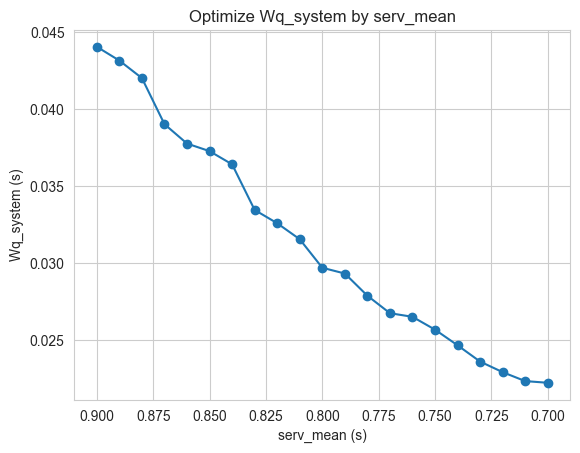

In [86]:
def optimize_by_serv_mean(serv_grid=None,
                          **kwargs):
    if serv_grid is None:
        serv_grid = [0.9 - i / 100 for i in range(21)]
    results = []
    for serv_mean in serv_grid:
        agg, _ = replicate(n=10, serv_mean=serv_mean, **kwargs)
        results.append((serv_mean, agg['Wq_system'], agg))
    best = min(results, key=lambda t: t[1])
    return best, results

best, results = optimize_by_serv_mean(
    sim_time=3600, arr_mean=0.8, serv_cap=2,
    use_cache=True, cache_mean=0.03, p_hit=0.5,
    use_log=True,   log_mean=0.05
)
print(f"Best serv_mean={best[0]:.2f} s  →  Wq_system={best[1]:.3f} s")

xs = [r[0] for r in results]
ys = [r[1] for r in results]
plt.plot(xs, ys, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("serv_mean (s)")
plt.ylabel("Wq_system (s)")
plt.title("Optimize Wq_system by serv_mean")
plt.grid(True)
plt.show()

Best p_hit=0.95  →  Wq_system=0.004 s


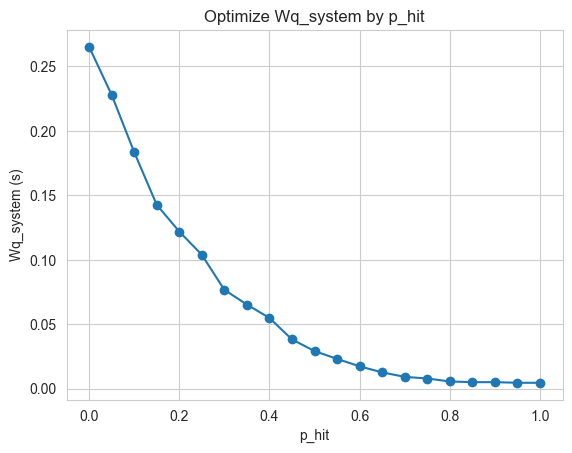

In [89]:
def optimize_by_p_hit(p_grid=None,
                      **kwargs):
    if p_grid is None:
        p_grid = [i / 20 for i in range(21)]
    results = []
    for p in p_grid:
        agg, _ = replicate(n=10, p_hit=p, **kwargs)
        results.append((p, agg['Wq_system'], agg))
    best = min(results, key=lambda t: t[1])
    return best, results

best_p, results_p = optimize_by_p_hit(
    sim_time=3600, arr_mean=0.8, serv_mean=0.8, serv_cap=2,
    use_cache=True, cache_mean=0.03,
    use_log=True,   log_mean=0.05
)
print(f"Best p_hit={best_p[0]:.2f}  →  Wq_system={best_p[1]:.3f} s")

xs = [r[0] for r in results_p]
ys = [r[1] for r in results_p]
plt.plot(xs, ys, marker='o')
plt.xlabel("p_hit")
plt.ylabel("Wq_system (s)")
plt.title("Optimize Wq_system by p_hit")
plt.grid(True)
plt.show()

Best cache_cap=3.00 s  →  Wq_system=0.028 s


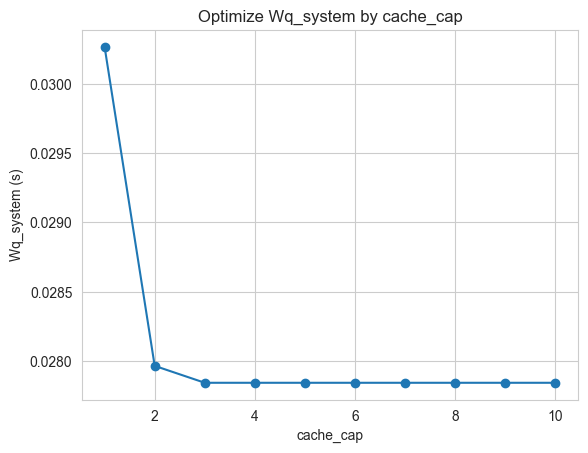

In [87]:
def optimize_by_cache_cap(serv_grid=None,
                          **kwargs):
    if serv_grid is None:
        serv_grid = [i for i in range(1, 10 + 1)]
    results = []
    for cache_cap in serv_grid:
        agg, _ = replicate(n=20, cache_cap=cache_cap, **kwargs)
        results.append((cache_cap, agg['Wq_system'], agg))
    best = min(results, key=lambda t: t[1])
    return best, results

best, results = optimize_by_cache_cap(
    sim_time=3600, arr_mean=0.8, serv_mean=0.8, serv_cap=2,
    use_cache=True, cache_mean=0.03, p_hit=0.5,
    use_log=True,   log_mean=0.05
)
print(f"Best cache_cap={best[0]:.2f} s  →  Wq_system={best[1]:.3f} s")

xs = [r[0] for r in results]
ys = [r[1] for r in results]
plt.plot(xs, ys, marker='o')
plt.xlabel("cache_cap")
plt.ylabel("Wq_system (s)")
plt.title("Optimize Wq_system by cache_cap")
plt.grid(True)
plt.show()